In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Initial Data Description

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
# Dropping the Cabin feature since the column is missing 77% of its values
missing_v = train["Cabin"].isna().sum()
total_v = 891
percent = missing_v*100/total_v
percent

77.10437710437711

In [5]:
#  Droppping "redundant" features
def clean(data):
    data = data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
    return data


In [6]:
#Re-defining the df with which we will work with
train_drp = clean(train)
test_drp = clean(test)

In [ ]:
train_drp.head(5)

In [8]:
def count_na (data):
    list_miss = []
    list_percent = []
    cols = data.columns
    for col in cols:
        missing_values = data[col].isna().sum()
        list_miss.append(missing_values)
        percent = missing_values*100/len(data[col])
        list_percent.append(round(percent, 2))
    df_miss = pd.DataFrame(list_miss).T
    df_miss.columns = data.columns
    df_percent = pd.DataFrame(list_percent).T
    df_percent.columns = data.columns
    df_miss.loc[1] = df_percent.loc[0]
    df_miss.index = ["Total", "Percent"]
    return df_miss


In [9]:
train_na = count_na(train_drp)
test_na = count_na(test_drp)



In [10]:
train_na

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Total,0.0,0.0,0.0,177.00,0.0,0.0,0.0,2.00
Percent,0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.22


In [11]:
test_na

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Total,0.0,0.0,86.00,0.0,0.0,1.00,0.0
Percent,0.0,0.0,20.57,0.0,0.0,0.24,0.0


Only the columns Age and Fare seem to have missing values on both our trainning and testing data sets.
However, it appears that the missing values for Fare are small enough (Train: 0.22% | Test: 0.24 %) that 
the best course of action would probably be to leave them as is. 

On the other hand, our Age columns have a large number of missing values that should be taken care of 
(Train: 19.87% | Test: 20.57). 

In order to determine the procedure by which we will fill in these values we must first see if there is
any pattern to the missing data or if it is completly at random.
If the missing values are spread randomly throughout the sample we could make use of the sample average
if the distribution follows a normal/Gaussian distribution. Else, it would probably better to replace 
these random missing values through the use of the median.

However, if the missing values are not at random, more sofisticate approaches should be used to interporlate
the date more accurately.

In order to check if these missing values are at random or not we will examin the distribution of the other
column's values based on wether they belong to the null subsampling or non-null subsample.

# Data Interpolation Assesment

**Functions for Age Null Value Distribution**

In [12]:
# We divide our samples (Training and Test) into its respective subsamples (Null and Not Null)
# with respect to ["Age"]
train_null = train_drp[train_drp["Age"].isna()]
train_not_null = train_drp[train_drp["Age"].notnull()]

test_null = test_drp[test_drp["Age"].isna()]
test_not_null = test_drp[test_drp["Age"].notnull()]

In [23]:
# We create a function to determine the distribution of our subsample based
# on percentages.
def percent_n(data_col):
    Total = data_col.groupby(data_col).count()
    Percent = data_col.groupby(data_col).count()
    for i in Total.index:    
        Percent[i] = round(Percent[i]*100/Total.sum(), 2)
    df = pd.DataFrame({'Total': Total, 'Percent': Percent}, columns=['Total', 'Percent'])
    return df

In [240]:
# We create a function incorporating the previous one in order to test differences
# between our sub samples to check if the distribution of null values present
# in our Age column is spread evenly and therefore due to random causes. 
# The input of this function is the name of the column we wish to examine.
# The output of this function is a DataFrame containing both: 
# Intra subsample differences
# Train[Null] - Train[NotNull] & Test[Null] - Test[NotNull]
# and Inter subsample differences:
# Train[Null] - Test[Null] & Train[NotNull] - Test[NotNull]
# if the missing values are due to random factors the spread will be even
# and the differences will be similar. If they are uneven, the missing
# values are due to a non-random cause and therefore should be interpolated
# through multivariate means.

def feature_inf(Feature):
    # Train Data
    p_null_s_Feature_tr = percent_n(train_null[str(Feature)])
    p_notnull_s_Feature_tr = percent_n(train_not_null[str(Feature)])

    # Test Data
    p_null_s_Feature_tst = percent_n(test_null[str(Feature)])
    p_notnull_s_Feature_tst = percent_n(test_not_null[str(Feature)])

    # Intra Subsample (Null x Not Null) Comparison
    Intra_dif_tr = p_null_s_Feature_tr["Percent"].subtract(p_notnull_s_Feature_tr["Percent"], fill_value=0)
    Intra_dif_tst = p_null_s_Feature_tst["Percent"].subtract(p_notnull_s_Feature_tst["Percent"], fill_value=0)

    # Inter Subsample (Train x Test) Comparisons
    Inter_dif_null = p_null_s_Feature_tr["Percent"].subtract(p_null_s_Feature_tst["Percent"], fill_value=0)
    Inter_dif_not_null = p_notnull_s_Feature_tr["Percent"].subtract(p_notnull_s_Feature_tst["Percent"], fill_value=0)

    # Sets the correct amount of indexes
    indx = Intra_dif_tr.index.values.tolist() + Intra_dif_tst.index.values.tolist() + Inter_dif_null.index.values.tolist() + Inter_dif_not_null.index.values.tolist()
    indx = set(indx)

    # Creating a joint DF for better comparison
    df = pd.DataFrame(Intra_dif_tr.reindex(indx))
    df.columns = ["Intra_dif_tr"]
    df["Intra_dif_tst"] = pd.DataFrame(Intra_dif_tst)
    df["Inter_dif_null"] = pd.DataFrame(Inter_dif_null)
    df["Inter_dif_not_null"] = pd.DataFrame(Inter_dif_not_null)
    return df

In [194]:
# Function which returns the absolute difference between our comparisons
def abs_dif(df):
    MIntra_dif_tr = round(df["Intra_dif_tr"].abs().sum()/2,2)
    MIntra_dif_tst = round(df["Intra_dif_tst"].abs().sum()/2,2)
    MInter_dif_null = round(df["Inter_dif_null"].abs().sum()/2,2)
    MInter_dif_not_null = round(df["Inter_dif_not_null"].abs().sum()/2,2)
    list = [MIntra_dif_tr, MIntra_dif_tst, MInter_dif_null, MInter_dif_not_null]
    list = pd.DataFrame(list).T
    list.columns = ["Intra_dif_tr", "Intra_dif_tst", "Inter_dif_null", "Inter_dif_not_null"]
    list.index = ["Abs Diff"]
    return list

**Survival**

In [14]:
# Examining Survival distribution between Train_Null and Train_Not_Null subsamples.
# Note: Test is not examined since it does not contain this particular column.
p_null_s_Age = percent_n(train_null["Survived"])
p_notnull_s_Age = percent_n(train_not_null["Survived"])

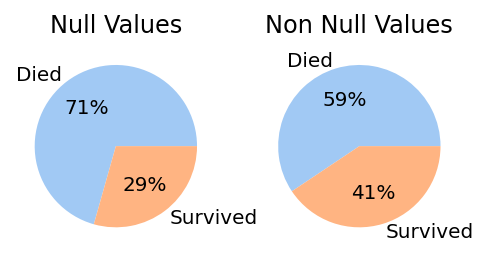

In [15]:
# Plotting Results
import matplotlib.pyplot as plt
import seaborn as sns

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]


## Plotting using seaborn


fig = plt.figure(figsize=(4,3), dpi=144)
ax = fig.add_subplot(121)
ax1 = plt.pie(p_null_s_Age["Total"], labels = ['Died', 'Survived'], colors = colors, autopct='%.0f%%')
ax.set_title("Null Values")

ax = fig.add_subplot(122)
ax2 = plt.pie(p_notnull_s_Age["Total"], labels = ['Died', 'Survived'], colors = colors, autopct='%.0f%%')
ax.set_title("Non Null Values")
plt.show()

The distribution percentages Survived/Died seem to differ between null and non null subsamples.
One would expect them to be similar if the error was random, but it may be systematic.
URL of interest: 
https://www.mastersindatascience.org/learning/how-to-deal-with-missing-data/
https://blogs.oracle.com/ai-and-datascience/post/3-methods-to-handle-missing-data
    - Random Forest
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/
    The cases of MNAR data are problematic. The only way to obtain an unbiased estimate of the 
    parameters in such a case is to model the missing data. The model may then be incorporated 
    into a more complex one for estimating the missing values.
    - Regression imputation

https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/#:~:text=There%20are%202%20primary%20ways,Imputing%20the%20Missing%20Values

We proceed examining the rest of the columns to check if this pattern of apperent non-randomness is also
present within them.

**Passanger Class**

In [246]:
Passanger_Class = feature_inf("Pclass")
Passanger_Class

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Pclass,,,,
1,-9.10,-19.05,6.48,-3.47
2,-18.02,-20.70,0.40,-2.28
3,27.12,39.74,-6.88,5.74


In [275]:
abs_PassClass = abs_dif(Passanger_Class)
abs_PassClass

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Abs Diff,27.12,39.75,6.88,5.75


**Sex**

In [254]:
Sex = feature_inf("Sex")
Sex

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Sex,,,,
female,-6.61,-9.18,0.87,-1.7
male,6.61,9.18,-0.87,1.7


In [274]:
abs_Sex = abs_dif(Sex)
abs_Sex

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Abs Diff,6.61,9.18,0.87,1.7


Distribution seems to also differ between subsamples with a 6.61% (Train) and a 9.18% (Test) difference.
This difference drops when comparing same type subsamples across samples (Train[Null]xTest[Null] & 
Train[NotNull]xTest[NotNull]) falling to 0.87% and 1.7% respectively. This hints at the possibility
of greater similarity between the test and train subsamples. This would mean that a multivariate approach
could use both samples in order to interpolate the missing Age values. 
If other columns exhibit similar behavior, with respect to uneven distribution of null values across
features(columns) we could then incorporate them into our multivariate interpolation. 





**Number of Siblings**

In [263]:
Number_Sib = feature_inf("SibSp")
Number_Sib

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
SibSp,,,,
0,11.43,15.77,-2.83,1.51
1,-10.94,-14.10,-0.43,-3.59
2,-1.81,0.18,-1.80,0.19
3,0.58,-1.20,2.26,0.48
4,-2.52,-1.20,NaN,1.32
5,-0.70,-0.30,NaN,0.40
8,3.95,0.86,2.79,-0.30


In [273]:
abs_NumbSib = abs_dif(Number_Sib)
abs_NumbSib

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Abs Diff,15.96,16.81,5.06,3.9


**Parch**

In [260]:
Parch = feature_inf("Parch")

In [272]:
abs_Parch = abs_dif(Parch)
abs_Parch

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Abs Diff,15.73,18.31,4.32,1.8


Notes on the resulting df

**Fare**

In [224]:
# Grouping fare prices by intervals of 10
def fare_price(data):
    data["Fare_Price"] = pd.cut(x=data['Fare'], bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230])
    df_fp = data["Fare_Price"].groupby(data["Fare_Price"]).count()
    df_fp = pd.DataFrame(df_fp)
    df_fp.columns = ["Count"]
    return df_fp

In [262]:
# Obtaining the proportions of our distribution
def fare_percent(data):
    from cmath import nan
    df_fp = fare_price(data)
    df_fp["Percent"] = nan
    for i in df_fp.index:
        df_fp["Percent"][i] = round(df_fp["Count"][i]*100/df_fp["Count"].sum(), 2)
    return df_fp


In [ ]:
# Train Data
p_null_s_Fare_tr = fare_percent(train_null)
p_notnull_s_Fare_tr = fare_percent(train_not_null)

# Test Data
p_null_s_Fare_tst = fare_percent(test_null)
p_notnull_s_Fare_tst = fare_percent(test_not_null)

# Intra Subsample (Null x Not Null) Comparison
Intra_dif_tr = p_null_s_Fare_tr["Percent"].subtract(p_notnull_s_Fare_tr["Percent"])
Intra_dif_tst = p_null_s_Fare_tst["Percent"].subtract(p_notnull_s_Fare_tst["Percent"])

# Inter Subsample (Train x Test) Comparisons
Inter_dif_null = p_null_s_Fare_tr["Percent"].subtract(p_null_s_Fare_tst["Percent"])
Inter_dif_not_null = p_notnull_s_Fare_tr["Percent"].subtract(p_notnull_s_Fare_tst["Percent"])

# Creating a joint DF for better comparison
Fare = pd.DataFrame(Intra_dif_tr)
Fare.columns = ["Intra_dif_tr"]
Fare["Intra_dif_tst"] = pd.DataFrame(Intra_dif_tst)
Fare["Inter_dif_null"] = pd.DataFrame(Inter_dif_null)
Fare["Inter_dif_not_null"] = pd.DataFrame(Inter_dif_not_null)
Fare

In [271]:
abs_Fare = abs_dif(Fare)
abs_Fare

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Abs Diff,25.44,30.76,10.09,6.64


**Embarked**

In [267]:
Embarked = feature_inf("Embarked")
Embarked

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Embarked,,,,
S,-26.96,-19.83,2.01,9.14
Q,23.75,21.28,-0.23,-2.70
C,3.21,-1.44,-1.79,-6.44


In [269]:
abs_Embarked = abs_dif(Embarked)
abs_Embarked

,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
Abs Diff,26.96,21.28,2.02,9.14


# Findings on Null Value Distribution

In [373]:
df_lst = [abs_PassClass, abs_Sex, abs_NumbSib, abs_Parch, abs_Fare, abs_Embarked]
Null_Age_Distribution = pd.concat(df_lst)
index_lst = ["PassClass", "Sex", "NumbSib", "Parch", "Fare", "Embarked"]

# Adding the overall average
Null_Age_Distribution.index = index_lst
col = Null_Age_Distribution.columns
mean_lst = []
for col in Null_Age_Distribution:
    mean_lst.append(round(Null_Age_Distribution[col].mean(),2))
col = Null_Age_Distribution.columns
mean = pd.DataFrame(mean_lst).T
mean.columns = col
Null_Age_Distribution = Null_Age_Distribution.append(mean)
Null_Age_Distribution = Null_Age_Distribution.rename(index={0:"Mean"})

Null_Age_Distribution

C:\Users\chiaw\AppData\Local\Temp\ipykernel_2732\2191437407.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Null_Age_Distribution = Null_Age_Distribution.append(mean)


,Intra_dif_tr,Intra_dif_tst,Inter_dif_null,Inter_dif_not_null
PassClass,27.12,39.75,6.88,5.75
Sex,6.61,9.18,0.87,1.70
NumbSib,15.96,16.81,5.06,3.90
Parch,15.73,18.31,4.32,1.80
Fare,25.44,30.76,10.09,6.64
Embarked,26.96,21.28,2.02,9.14
Mean,19.64,22.68,4.87,4.82
